In [ ]:
#importing libraries 
import numpy as np
import pandas as pd

from PIL import Image, ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
import cv2

from tqdm import tqdm_notebook as tqdm
from functools import partial
import scipy as sp

import random
import time
import sys
import os

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn import metrics
from sklearn.metrics import confusion_matrix

from typing import Dict, List

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import transforms, models, datasets
from torch.utils.data import Dataset
from torch.autograd import Variable
import torch.nn.functional as F

from efficientnet_pytorch import EfficientNet

import warnings
warnings.filterwarnings('ignore')
#!mkdir models

In [ ]:
#!pip install alibi[torch]
import alibi

from alibi.explainers import CounterfactualRL
from alibi.models.pytorch import AE
from alibi.models.pytorch import Actor, Critic
#from alibi.models.pytorch import MNISTEncoder, MNISTDecoder, MNISTClassifier
from alibi.explainers.cfrl_base import Callback
from alibi.models.pytorch.model import Model

In [ ]:
# JHA (240403): changed the Alibi MNISTEncoder, MNISTDEcoder, MNISTClassifier from 1 channel (gray-scale) to 3 channels (RGB)

class MNISTClassifier(Model):
    """
    MNIST classifier used in the experiments for Counterfactual with Reinforcement Learning. The model consists of two
    convolutional layers having 64 and 32 channels and a kernel size of 2 with ReLU nonlinearities, followed by
    maxpooling of size 2 and dropout of 0.3. The convolutional block is followed by a fully connected layer of 256 with
    ReLU nonlinearity, and finally a fully connected layer is used to predict the class logits (10 in MNIST case).
    """
    def __init__(self, output_dim: int) -> None:
        """
        Constructor.

        Parameters
        ----------
        output_dim
            Output dimension.
        """
        super().__init__()

        self.conv1 = nn.Conv2d(3, 64, kernel_size=(2, 2), padding=1) 
        self.maxpool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout1 = nn.Dropout(0.3)
        self.conv2 = nn.Conv2d(64, 32, kernel_size=(2, 2), padding=1)
        self.maxpool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout2 = nn.Dropout(0.3)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(1568, 256)
        self.fc2 = nn.Linear(256, output_dim)

        # send to device
        self.to(self.device)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Forward pass.

        Parameters
        ----------
        x
            Input tensor.

        Returns
        -------
        Classification logits.
        """
        x = self.dropout1(self.maxpool1(F.relu(self.conv1(x))))
        x = self.dropout2(self.maxpool2(F.relu(self.conv2(x))))
        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


class MNISTEncoder(nn.Module):
    """
    MNIST encoder used in the experiments for the Counterfactual with Reinforcement Learning. The model
    consists of 3 convolutional layers having 16, 8 and 8 channels and a kernel size of 3, with ReLU nonlinearities.
    Each convolutional layer is followed by a maxpooling layer of size 2. Finally, a fully connected layer
    follows the convolutional block with a tanh nonlinearity. The tanh clips the output between [-1, 1], required
    in the DDPG algorithm (e.g., [act_low, act_high]). The embedding dimension used in the paper is 32, although
    this can vary.
    """

    def __init__(self, latent_dim: int):
        """
        Constructor.

        Parameters
        ----------
        latent_dim
            Latent dimension.
        """
        super().__init__()

        self.conv1 = nn.Conv2d(3, 16, kernel_size=(3, 3), padding=1)
        self.maxpool1 = nn.MaxPool2d((2, 2), stride=2)
        self.conv2 = nn.Conv2d(16, 8, kernel_size=(3, 3), padding=1)
        self.maxpool2 = nn.MaxPool2d((2, 2), stride=2)
        self.conv3 = nn.Conv2d(8, 8, kernel_size=(3, 3), padding=1)
        self.maxpool3 = nn.MaxPool2d((2, 2), stride=2)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(8192, latent_dim) # JHA (240403): original 8192 -> 8*4*4

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Forward pass.

        Parameters
        ----------
        x
            Input tensor.

        Returns
        -------
        Encoding representation having each component in the interval [-1, 1]
        """
        x = self.maxpool1(F.relu(self.conv1(x)))
        x = self.maxpool2(F.relu(self.conv2(x)))
        x = self.maxpool3(F.relu(self.conv3(x)))
        x = self.flatten(x)
        x = torch.tanh(self.fc1(x))
        return x

class MNISTDecoder(nn.Module):
    """
    MNIST decoder used in the Counterfactual with Reinforcement Learning experiments. The model consists of a fully
    connected layer of 128 units with ReLU activation followed by a convolutional block. The convolutional block
    consists fo 4 convolutional layers having 8, 8, 8  and 1 channels and a kernel size of 3. Each convolutional layer,
    except the last one, has ReLU nonlinearities and is followed by an upsampling layer of size 2. The final layers
    uses a sigmoid activation to clip the output values in [0, 1].
    """

    def __init__(self, latent_dim: int):
        """
        Constructor.

        Parameters
        ----------
        latent_dim
            Latent dimension.
        """
        super().__init__()

        self.fc1 = nn.Linear(latent_dim, 8192)
        self.conv1 = nn.Conv2d(8, 8, kernel_size=(3, 3), padding=1)
        self.up1 = nn.Upsample(scale_factor=2)
        self.conv2 = nn.Conv2d(8, 8, kernel_size=(3, 3), padding=1)
        self.up2 = nn.Upsample(scale_factor=2)
        self.conv3 = nn.Conv2d(8, 16, kernel_size=(3, 3), padding=1)
        self.up3 = nn.Upsample(scale_factor=2)
        self.conv4 = nn.Conv2d(16, 3, kernel_size=(3, 3), padding=1)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Forward pass.

        Parameters
        ----------
        x
            Input tensor.

        Returns
        -------
        Decoded input having each component in the interval [0, 1].
        """
        x = F.relu(self.fc1(x))
        x = x.view(x.shape[0], 8, 32, 32)
        x = self.up1(F.relu(self.conv1(x)))
        x = self.up2(F.relu(self.conv2(x)))
        x = self.up3(F.relu(self.conv3(x)))
        x = torch.sigmoid(self.conv4(x))
        return x


In [ ]:
# seed function
def seed_everything(seed = 23):
    # tests
    assert isinstance(seed, int), 'seed has to be an integer'
    
    # randomness
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [ ]:
#GPU CHECK
train_on_gpu = torch.cuda.is_available()
if not train_on_gpu:
    print('CUDA is not available. Training on CPU...')
    device = torch.device('cpu')
else:
    print('CUDA is available. Training on GPU...')
    device = torch.device('cuda:0')

In [ ]:
#RANDOMNESS
seed = 98
seed_everything(seed)

Load DR Dataset

In [ ]:
# Define constants.
BATCH_SIZE = 64
BUFFER_SIZE = 1024

# Load MNIST dataset.
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Define trainset.
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True)

# Define testset.
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE, shuffle=True)

In [ ]:
%run xai_setting.py

In [ ]:
#DATA PREPARATION

# load splits
data_train = train
data_valid = test

# create datasets
train_dataset = EyeData(data      = data_train, 
                             directory = './input/diabetic-retinopathy-resized/resized_train/train',   # JHA (240403): original directory is ./resized_train
                             transform = train_trans,
                             itype ='.jpeg')
valid_dataset = EyeData(data       = data_valid, 
                            directory  = './input/aptos2019-blindness-detection/train_images',
                            transform  = valid_trans,
                            itype ='.png')

# create data loaders
train_loader = torch.utils.data.DataLoader(train_dataset, 
                                           batch_size  = batch_size, 
                                           shuffle     = True, 
                                           num_workers = 0)
valid_loader = torch.utils.data.DataLoader(valid_dataset, 
                                           batch_size  = batch_size, 
                                           shuffle     = False, 
                                           num_workers = 0)

Define already-trained classifier

In [ ]:
'''
#I/O with regards to .bin files

#Loading model for inference
model = EfficientNet.from_pretrained('efficientnet-b7', num_classes = 5)
model.load_state_dict(torch.load('C:/rsrch/240305_TorchDR/models/model_enet_b7_fold4.bin'))
model.eval()


# Loading model for training
# Load the .bin model
model = torch.load('C:/rsrch/240305_TorchDR/models/model_enet_b7_fold4.bin')
# Set the model to training mode
model.train()
'''

classifier = model = EfficientNet.from_pretrained('efficientnet-b7', num_classes = 5)

Define the predictor (black-box)

In [ ]:
# Define predictor function (black-box) used to train the CFRL
def predictor(X: np.ndarray):
    Y = classifier(X).numpy()
    return Y

Define and train autoencoder

In [ ]:
class AE(nn.Module):
    def __init__(self, encoder: nn.Module, decoder: nn.Module):
        super(AE, self).__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, x):
        z = self.encoder(x)
        x_hat = self.decoder(z)
        return x_hat

In [ ]:
# Define autoencoder trainset.
trainset_ae = train_loader

# Define autoencode testset.
testset_ae = valid_loader


In [ ]:
# Define autoencoder path and create dir if it doesn't exist.
ae_path = os.path.join("pytorch", "DR_autoencoder")
if not os.path.exists(ae_path):
    os.makedirs(ae_path)
   
# Define latent dimension.
LATENT_DIM = 64
EPOCHS = 50

# Compile autoencoder.
ae = AE(encoder=MNISTEncoder(latent_dim=LATENT_DIM),
        decoder=MNISTDecoder(latent_dim=LATENT_DIM))
ae.to(device)
ae.train()

# Define optimizer and loss function.
criterion = nn.BCELoss()  #JHA (240403): Do not name the variable as 'loss', for it has an overriding issue
optimizer = torch.optim.Adam(ae.parameters(), lr=1e-3)

if len(os.listdir(ae_path)) == 0:
    # Fit and save autoencoder.
    # loop through batches
    for batch_i, data in enumerate(tqdm(train_loader)):

        # extract inputs and labels
        inputs = data['image']
        #labels = data['label'].view(-1)
        inputs = inputs.to(device, dtype = torch.float)
        optimizer.zero_grad()

        # forward and backward pass
        with torch.set_grad_enabled(True):
            preds = ae(inputs)
            loss  = criterion(preds, inputs)
            loss.backward()
            optimizer.step()
    torch.save(ae.state_dict(), os.path.join(ae_path, 'model_ae.bin'))
else:
    # Load the model.
    ae.load_state_dict(torch.load(os.path.join(ae_path, 'model_ae.bin')))
    ae.eval()

Test the autoencoder

In [ ]:
# Define number of samples to be displayed
NUM_SAMPLES = 5

# Get some random samples from test
np.random.seed(0)
indices = np.random.choice(len(valid_dataset), NUM_SAMPLES)

inputs = [valid_dataset[i]['image'].reshape(1, 3, 256, 256) for i in indices]
inputs = np.concatenate(inputs, axis=0)
inputs = torch.tensor

# Pass samples through the autoencoder
inputs_hat = ae(inputs).numpy()

In [254]:


# Define number of samples to be displayed
NUM_SAMPLES = 5

# Get some random samples from valid_dataset
np.random.seed(0)
indices = np.random.choice(len(valid_dataset), NUM_SAMPLES)
inputs = [valid_dataset[i]['image'] for i in indices]
inputs = torch.stack(inputs)
inputs = inputs.to(device, dtype = torch.float)

# Permute
ae_inputs = torch.permute(ae(inputs), (0, 2, 3, 1))
i_inputs = torch.permute(inputs, (0, 2, 3, 1))

# Pass samples through the autoencoder
inputs_cpu = i_inputs.detach().cpu().numpy()
inputs_hat = ae_inputs.detach().cpu().numpy()

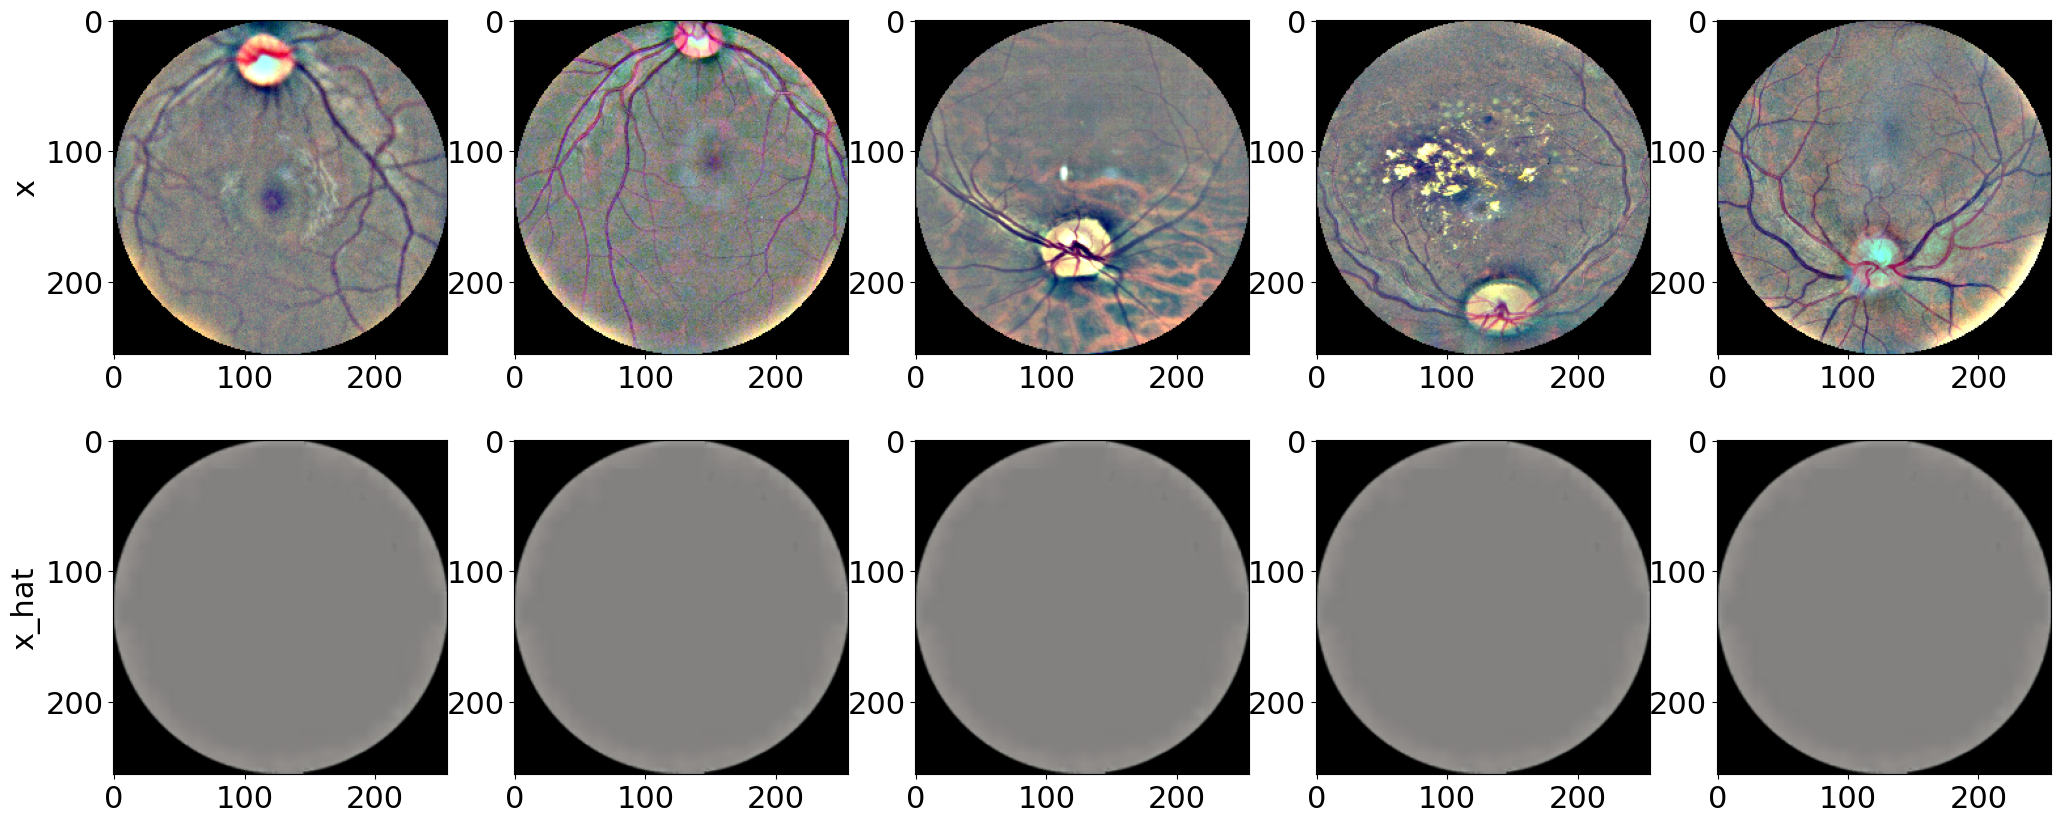

In [256]:
# Plot inputs and reconstructions.
plt.rcParams.update({'font.size': 22})
fig, ax = plt.subplots(2, NUM_SAMPLES, figsize=(25, 10))

for i in range(NUM_SAMPLES):
    ax[0][i].imshow(inputs_cpu[i])  # JHA (240403): original - cmap='gray'
    ax[1][i].imshow(inputs_hat[i])

text1 = ax[0][0].set_ylabel("x")
text2 = ax[1][0].set_ylabel("x_hat")

Counterfactual with Reinforcement Learning

In [258]:
# Define constants
COEFF_SPARSITY = 7.5               # sparisty coefficient
COEFF_CONSISTENCY = 0              # consisteny coefficient -> no consistency
TRAIN_STEPS = 50000                # number of training steps -> consider increasing the number of steps
BATCH_SIZE = 100                   # batch size

Define and fit the explainer

In [261]:
# Define explainer.
explainer = CounterfactualRL(predictor=predictor,
                             encoder=ae.encoder,
                             decoder=ae.decoder,
                             latent_dim=LATENT_DIM,
                             coeff_sparsity=COEFF_SPARSITY,
                             coeff_consistency=COEFF_CONSISTENCY,
                             train_steps=TRAIN_STEPS,
                             batch_size=BATCH_SIZE,
                             backend="pytorch")

In [263]:
# Fit the explainer
explainer = explainer(valid_dataset)


TypeError: 'CounterfactualRL' object is not callable